#### Preliminaries

First we import the libraries we will need, and the data.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import seaborn as sns
import math, dcor

%matplotlib inline

In [2]:
data = pd.read_csv('Table2_Hunt_2013_edit.csv')
data.describe()

,Gross pay,Phi-h,Position,Pressure,Random 1,Random 2,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,9.823810,68.880952,1.885714,15.285714,10.190476,292.714286,16.579524,33.428571
std,5.948521,45.167894,0.708721,2.759400,6.439092,59.429069,6.543793,15.141909
min,0.100000,0.500000,1.000000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,4.900000,24.600000,1.100000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,10.000000,72.900000,2.000000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,15.100000,100.000000,2.200000,17.000000,13.000000,340.000000,21.970000,44.200000
max,19.100000,160.000000,2.900000,20.000000,21.000000,395.000000,29.250000,59.200000


In [3]:
print (list(data))

['Gross pay', 'Phi-h', 'Position', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']


In [4]:
data = data.loc[:, ['Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']]
data.describe()

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1.885714,9.823810,68.880952,15.285714,10.190476,292.714286,16.579524,33.428571
std,0.708721,5.948521,45.167894,2.759400,6.439092,59.429069,6.543793,15.141909
min,1.000000,0.100000,0.500000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,1.100000,4.900000,24.600000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,2.000000,10.000000,72.900000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,2.200000,15.100000,100.000000,17.000000,13.000000,340.000000,21.970000,44.200000
max,2.900000,19.100000,160.000000,20.000000,21.000000,395.000000,29.250000,59.200000


#### Initial orrelation matrix with bivariate scatter-plots in the upper triangle, contours in the lower triangle, shape of the bivariate distributions on the diagonal

To ignore future warning for a [known issue](https://github.com/h5py/h5py/issues/974):

In [5]:
import warnings
warnings.filterwarnings("ignore")

#### Function to annotate individual scatterplots with rank correlation coefficient

In [6]:
def corrfunc(x, y, **kws):
    r, _ = sp.stats.spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("CC = {:.2f}".format(r), xy=(.1, .97), xycoords=ax.transAxes, color = 'g', fontsize = 15)

# https://stackoverflow.com/a/30942817

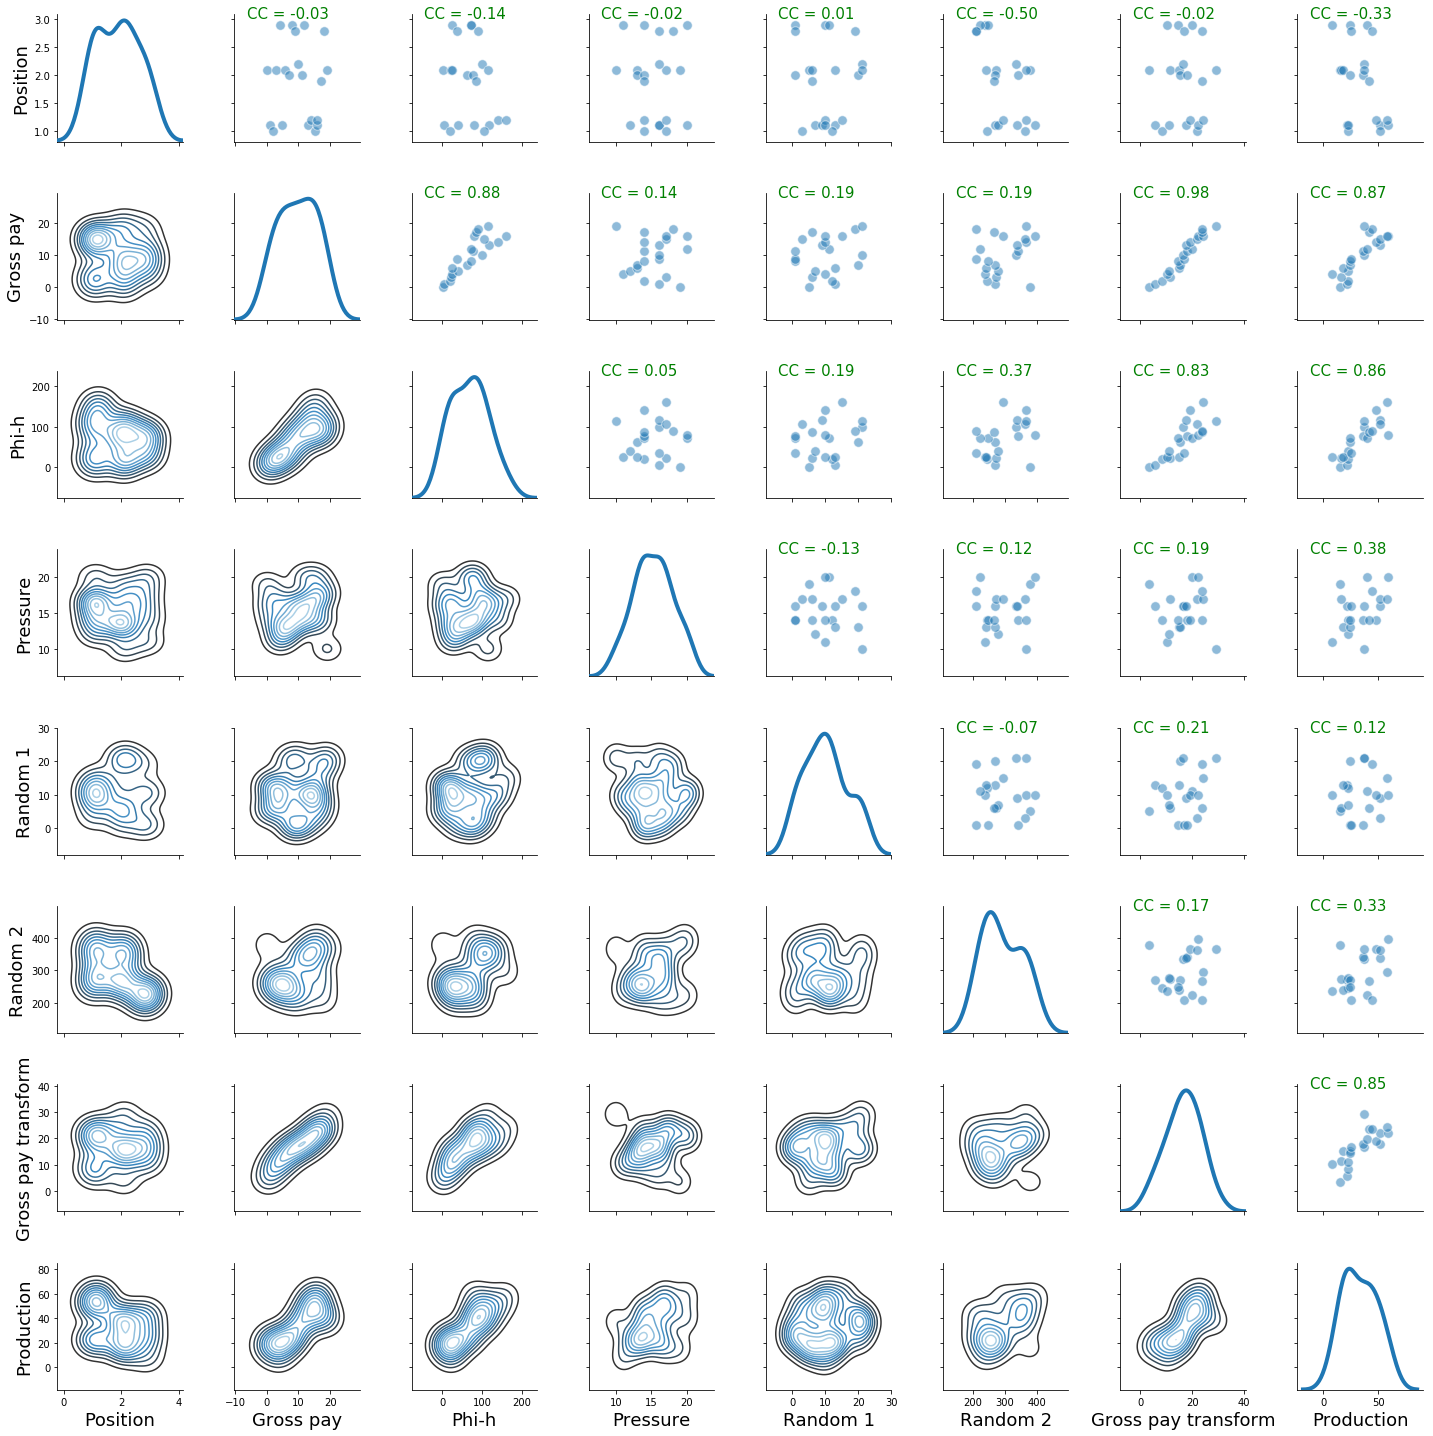

In [7]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes

g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)

g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")

plt.savefig('matrix_initial.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Confidence interval for the correlation coefficient

given the confidence level of 95%, the number of wells (and from that the degrees of freedom), and the sample correlation coefficient, we can calculate the confidence interval for the population correlation coefficient (P97.5 and P2.5).

Here's a convenient function to calculate it; for the details of the calculation, see <a href = "http://brownmath.com/stat/correl.htm#CI"> Brown</a>.

In [8]:
def confInt(r, nwells):
    z_crit = sp.stats.norm.ppf(.975)
    std_Z = 1/np.sqrt(nwells-3)
    E = z_crit*std_Z
    Z_star = 0.5*(np.log((1+r)/(1.0000000000001-r)))
    ZCI_l = Z_star - E
    ZCI_u = Z_star + E
    RCI_l = (np.exp(2*ZCI_l)-1)/(np.exp(2*ZCI_l)+1)
    RCI_u = (np.exp(2*ZCI_u)-1)/(np.exp(2*ZCI_u)+1)
    return RCI_u, RCI_l

In [9]:
prod_rs = data.corr(method = 'spearman').as_matrix()[-1,:-1]
prod_rs

array([-0.32832312,  0.86883117,  0.86103896,  0.38438956,  0.11730281,
        0.33138409,  0.85454545])

#### Critical r test

A good way is to compare the correlation coefficient to a threshold value called critical r. From the definitions, critical r is the value of the correlation coefficient at which you can rule out chance as an explanation for the relationship in the sample.

To calculate the critical r, we first get the number of wells and degrees of freedom.

In [10]:
nwells, nfeatures = data.shape
print ('nunber of wells =', nwells)
print ('df =' ,nwells-2)

nunber of wells = 21
df = 19


Further, we need to calculate the critical t (or inverse t) for the specific significance level (95%) and degrees of freedom we are considering. This can be found in Student's t distribution tables, but fortunately we can also calculate it using the statistical library from Scipy.

With alpha = 0.05 and df = (21 - 2) = 19, we get:

In [11]:
t = sp.stats.t.isf(0.025, nwells-2) # required input is alpha/2

which corresponds to the value we would get from <a href="http://growingknowing.com/GKStatsBookStudentTTable.html"> the Student's t distribution tables</a> at row 19 (df = 19), column 3 (2-tail alpha = 0.05).

With this value of t we calculate the critical r as (<a href="http://brownmath.com/stat/correl.htm#DecisionPoints">formula from Brown</a>):

\begin{equation*}
r = \frac{t}{\sqrt{df+t^2}} 
\end{equation*}

In [12]:
r_crit = t/np.sqrt((nwells-2)+ np.power(t,2))
print (r_crit)

0.4328575563165211


What is this number telling us?

It tells us that with 21 wells (19 degrees of freedom) and 5% as the maximum chance of being wrong we are willing to take (confidence level 95%),  we need a value of correlation coefficient of at least 0.43 to rule out chance as an explanation for a specific correlation.

#### Kalkomey's probability of spuriousness

In [13]:
def P_spurious (r, nwells, nattributes):
    t_of_r = r * np.sqrt((nwells-2)/(1-np.power(r,2)))  
    p = sp.stats.t.sf(np.abs(t_of_r), nwells-2)*2 
    ks = np.arange(1, nattributes+1, 1)
    return np.sum(p * np.power(1-p, ks-1))

In [14]:
print (np.array([P_spurious(r, 21, 1) for r in prod_rs]).round(decimals=3))

[0.146 0.    0.    0.085 0.613 0.142 0.   ]


The values above are the same you'd get below using 

`_, p = sp.stats.spearmanr(x, y)`

#### Function to annotate individual scatterplots with rank correlation coefficient, confidence interval coloured by r_critical test
#### probability of spuriousness coloured by 5% test

In [17]:
def corrfunc(x, y, **kws):
    r, p = sp.stats.spearmanr(x, y)
    u, l = confInt(r, 21)  
    if r > r_crit:
       rclr = 'g'
    else:
        rclr= 'm' 
    if p > 0.05:
       pclr = 'm'
    else:
        pclr= 'g'
    ax = plt.gca()
    ax.annotate("CC = {:.2f}".format(r), xy=(.1, 1.25), xycoords=ax.transAxes, color = rclr, fontsize = 14)
    ax.annotate("CI = [{:.2f} {:.2f}]".format(u, l), xy=(.1, 1.1), xycoords=ax.transAxes, color = rclr, fontsize = 14)
    ax.annotate("PS = {:.3f}".format(p), xy=(.1, .95), xycoords=ax.transAxes, color = pclr, fontsize = 14)
    
# https://stackoverflow.com/a/43669327/1034648

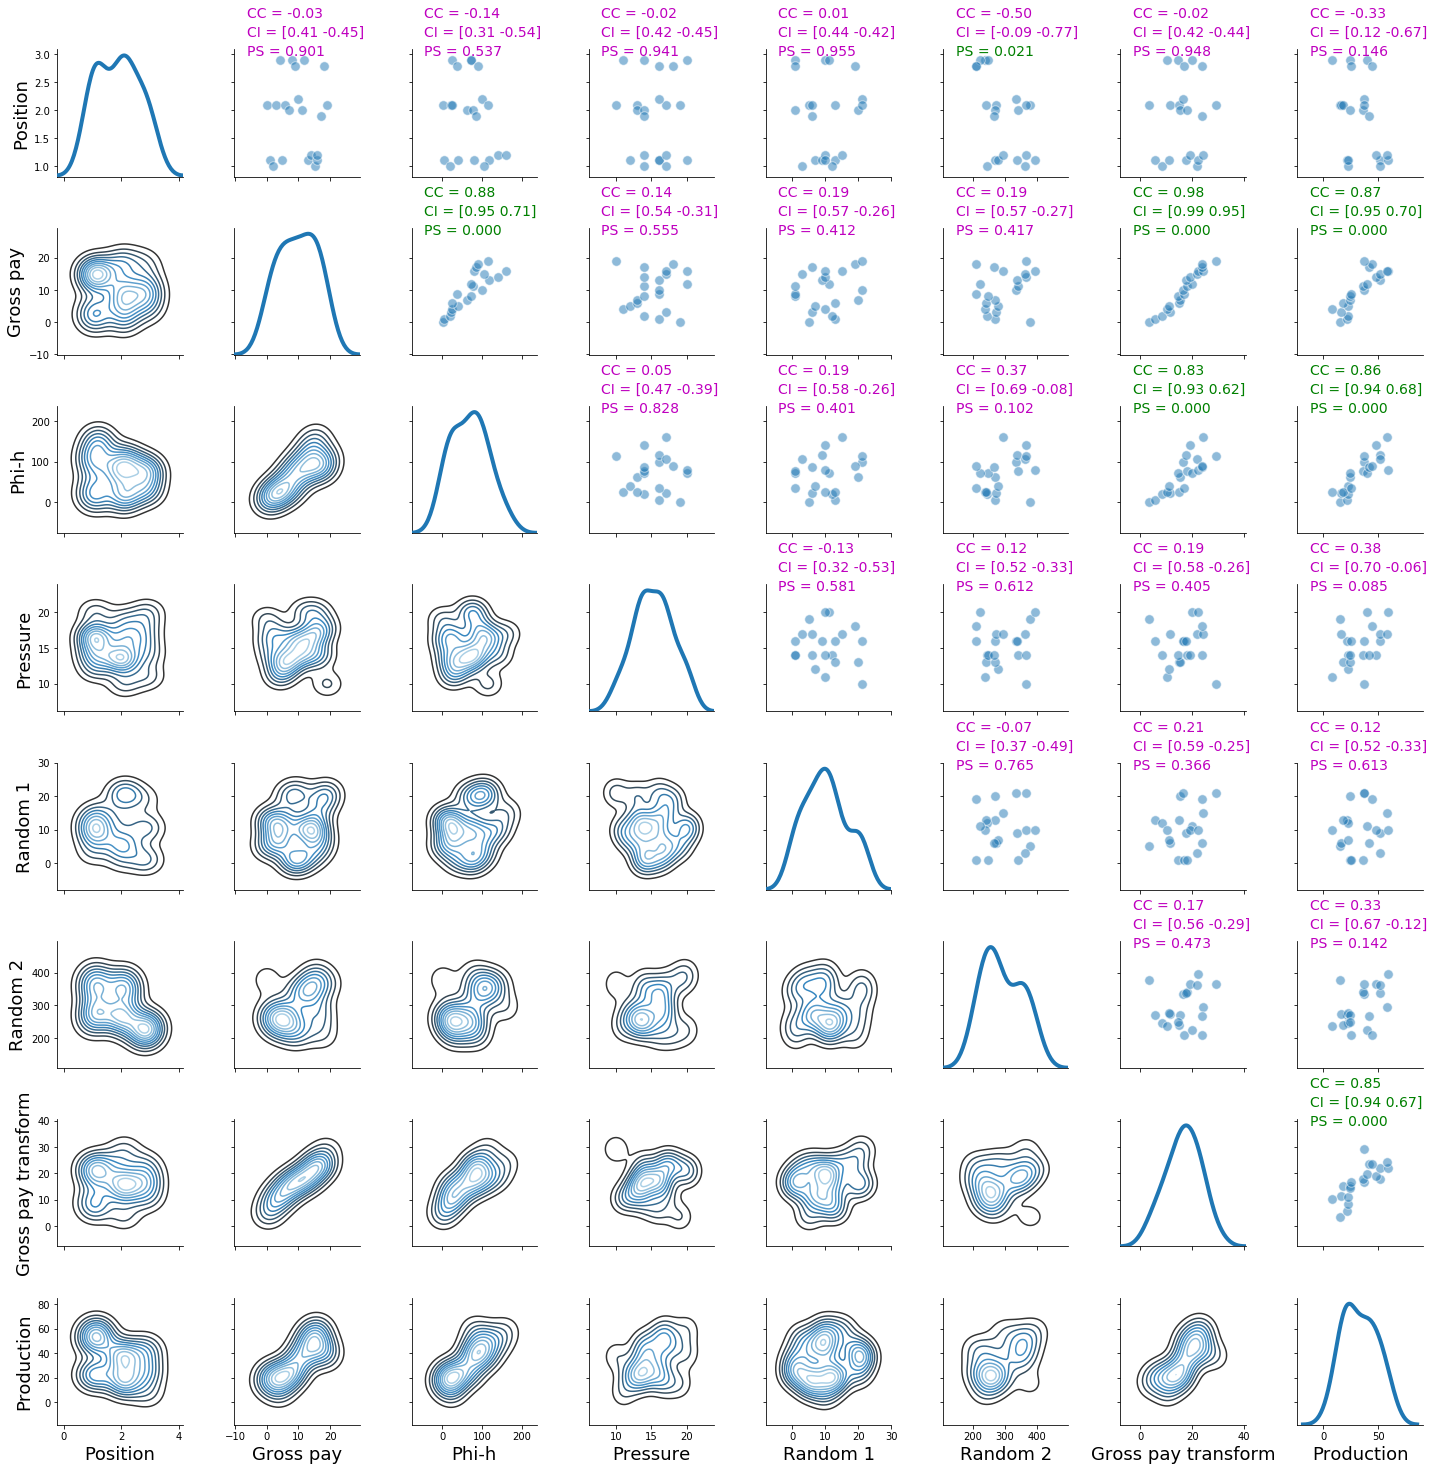

In [18]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes

g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)

g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")

plt.savefig('matrix_final.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

#### First observations:
- linear relationships:
- correlation coefficient vs. critical r:
- p-value
- Position (ranked position within the reservoir) seems to be a very important variable nothwidstanding the significance tests. Indeed, Gross-pay, Phi-h, Pressure, and Production all cluster according to position.
